# Logica del Juego

In [2]:
import numpy as np
import gym
import random
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plot

In [3]:
# 0 = empty_space; 1 = player; 2 = goal 
def draw_map(size, player_position, goal_position):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[player_position[1], player_position[0]] = 1
    map[goal_position[1], goal_position[0]] = 2
    
    return map

In [4]:

class GameEnviroment:
    def __init__(self, map, size, player_initial_state, goal_position):
        self.map = map
        self.size = size
        self.player_state = player_initial_state
        self.goal = goal_position 
        self.rewards = {
            "walk": -1,
            "fall": -5,
            "goal": 20
        }

    def __str__(self):
        return str(self.map) + f"\nPlayerPos: ({self.player_state[0]}, {self.player_state[1]})"
    
    def reset(self, initial_map, player_initial_state):
        self.map = initial_map
        self.player_state = player_initial_state
        return ((10 * self.player_state[0]) + self.player_state[1])

    def is_in_goal(self):
        return (self.player_state[0] == self.goal[0] and self.player_state[1] == self.goal[1])
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.player_state[1] not in y_range or self.player_state[0] not in x_range)

    def move_player_left(self):
        self.player_state[0] = self.player_state[0] - 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
    
    def move_player_right(self):
        self.player_state[0] = self.player_state[0] + 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False

    def move_player_up(self):
        self.player_state[1] = self.player_state[1] - 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
    
    def move_player_down(self):
        self.player_state[1] = self.player_state[1] + 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
        
    # 0 = LEFT, 1 = RIGHT, 2 = UP, 3 = DOWN
    def step(self, action):
        if action == 0:
            new_state, reward, done = self.move_player_left()
        if action == 1:
            new_state, reward, done = self.move_player_right()
        if action == 2:
            new_state, reward, done = self.move_player_up()
        if action == 3:
            new_state, reward, done = self.move_player_down()

        # applying wind
        PrA = 0.1
        PrB = 0.2
        PrC = 0.15
        if self.player_state[0] == 3:
            random_number = np.random.uniform(low=0.0, high=1.0)
            if random_number <= PrA:
                new_state, reward, done = self.move_player_up()
        
        if self.player_state[0] == 4:
            random_number = np.random.uniform(low=0.0, high=1.0)
            if random_number <= PrB:
                new_state, reward, done = self.move_player_up()
                new_state, reward, done = self.move_player_up()

        if self.player_state[0] == 5:
            random_number = np.random.uniform(low=0.0, high=1.0)
            if random_number <= PrC:
                new_state, reward, done = self.move_player_up()
        
        return new_state, reward, done

In [5]:
map_size = [9, 7]
player_initial_pos = [1, 1]
goal_pos = [7, 4]

initial_map = draw_map(map_size, player_initial_pos, goal_pos)
env = GameEnviroment(initial_map, map_size, player_initial_pos, goal_pos)
print(env)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
PlayerPos: (1, 1)


Inicializando parametros 

In [6]:
num_episodes = 15000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95

rewards_avg = []

action_space_size = 4
state_space_size = 200

q_table = np.zeros((state_space_size, action_space_size))

Corriendo el algoritmo Q-Learning

In [7]:
# This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learn how to maximize the reward.
for it in range(100):
    print('average ', it)
    rewards_all_episodes=[]
    
    # exporation-exploitation trade-off params
    exploration_rate = 1
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005
    
    # init q table in zeros
    q_table = np.zeros((state_space_size, action_space_size))

    # iterate over the episodes
    for episode in range(num_episodes):
        player_initial_pos = [1, 1]
        initial_map = draw_map(map_size, player_initial_pos, goal_pos)
        state = env.reset(initial_map, player_initial_pos)
        done = False
        rewards_current_episode = 0
        
        # iterate over the steps for an episode
        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_rate_threshold = np.random.uniform(low=0.0, high=1.0)
            if exploration_rate_threshold <= exploration_rate:
                # Expl oration time
                action = np.random.randint(0, action_space_size)
            else:
                # Explotation time
                action = np.argmax(q_table[state])

            # Take action
            new_state, reward, done = env.step(action)

            # Update Q-table for Q(s,a)
            if done == True: 
                break
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
            # transition next state

            state = new_state
            rewards_current_episode += reward


        # Exploration rate decay
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (math.e ** (-exploration_decay_rate * episode))

        rewards_all_episodes.append(rewards_current_episode)
    rewards_avg.append(rewards_all_episodes)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

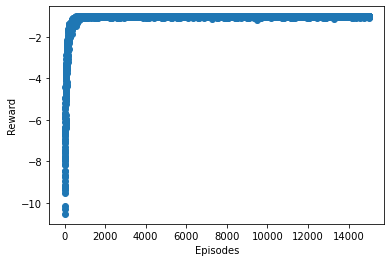

In [8]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [9]:
print(f"*****************q-table**************** \n {q_table}")

*****************q-table**************** 
 [[ 0.         -0.91410065  0.         -0.83222784]
 [ 0.         -1.95       -0.99999701 -0.99999997]
 [ 0.         -1.77403268 -0.95601953 -0.94502442]
 [ 0.         -0.36       -0.36       -0.67232   ]
 [ 0.         -0.5868     -0.36       -0.2       ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.99622211 -0.99900965  0.         -1.94142676]
 [-1.         -1.94998911 -1.         -1.94999995]
 [-1.         -2.20969942 -1.92328685 -1.38966985]
 [-0.737856   -1.32203929 -1.4137532  -0.8547808 ]
 [-0.5904     -0.63544    -0.801216   -0.5904    ]
 [ 0.          0.         -0.488      -0.36      ]
 [ 0.         -0.2        -0.2         0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          